<a href="https://colab.research.google.com/github/iliavk/rebalance-portfolio/blob/main/rebalance_simulation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Rebalancing Strategies: A Comparative Study

This project explores different portfolio rebalancing strategies for a simple two-asset portfolio composed of:
- **70% SPY** — an ETF tracking the S&P 500 index
- **30% BIL** — an ETF tracking short-term U.S. Treasury Bills (1–3 months)

We simulate and compare four approaches:
- **Daily rebalancing**
- **Monthly rebalancing**
- **Buy & hold**
- **Threshold-based rebalancing** (only rebalance when the stock weight drifts outside a specified tolerance)

We evaluate each strategy on:
- Compound Annual Growth Rate (CAGR)
- Volatility
- Sharpe Ratio
- Maximum Drawdown
- Number of rebalancing events (for threshold strategy)

All simulations use SPY daily data from **2010 to 2025** and assume a constant 5% annual return on T-Bills.

The goal is to understand how rebalancing frequency affects portfolio performance, trading cost, and risk-adjusted return.

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look better
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [11]:
# Download S&P 500 data
sp500_df = yf.download('^GSPC', start='2010-01-01', end='2024-12-31', auto_adjust=True)
sp500 = sp500_df['Close'].resample('ME').last().squeeze()

# Drop NaNs from sp500 just in case (especially early ones)
sp500 = sp500.dropna()

# Simulate constant monthly return (4% annualized)
tbill_monthly_return = (1 + 0.04) ** (1/12) - 1

# Create a Series of monthly T-Bill values starting at 1
tbill_values = (1 + tbill_monthly_return) ** np.arange(len(sp500))
tbill = pd.Series(tbill_values, index=sp500.index)

# Combine into DataFrame
prices = pd.DataFrame({'SP500': sp500, 'TBill': tbill})
prices.head()

[*********************100%***********************]  1 of 1 completed


,SP500,TBill
Date,,
2010-01-31,1073.869995,1.000000
2010-02-28,1104.489990,1.003274
2010-03-31,1169.430054,1.006558
2010-04-30,1186.689941,1.009853
2010-05-31,1089.410034,1.013159


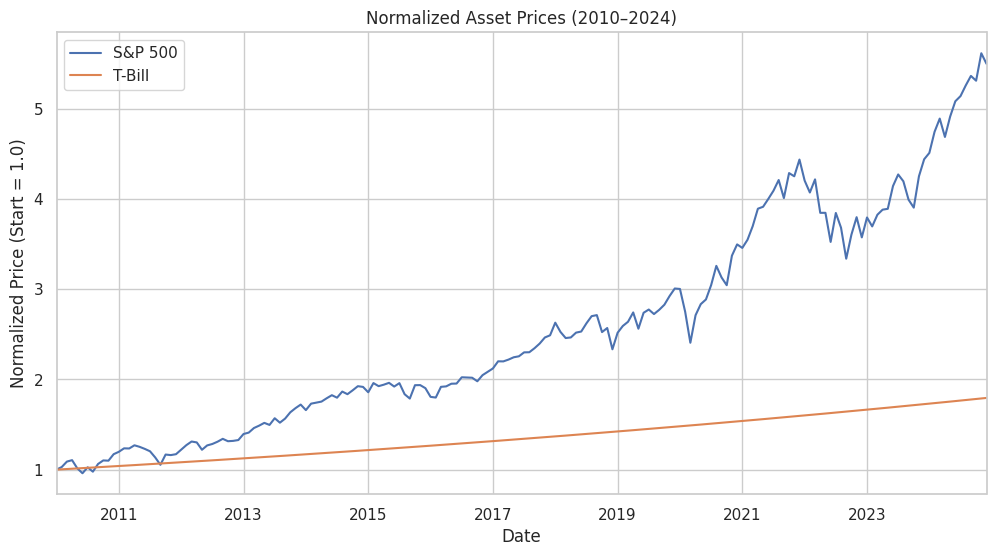

In [12]:
# Normalize both series to start at 1.0
sp500_norm = sp500 / sp500.iloc[0]
tbill_norm = tbill / tbill.iloc[0]

# Combine into a DataFrame for plotting
prices_norm = pd.DataFrame({
    'S&P 500': sp500_norm,
    'T-Bill': tbill_norm
})

# Plot the normalized prices
prices_norm.plot(figsize=(12, 6), title="Normalized Asset Prices (2010–2024)")
plt.ylabel("Normalized Price (Start = 1.0)")
plt.grid(True)
plt.show()

In [27]:
def simulate_portfolio(price_data,
                       rebalance_freq='daily',
                       initial_value=1000,
                       target_weights=(0.3, 0.7),
                       transaction_cost=0.0005,
                       threshold=0.05):  # for dynamic rebalance
    tbill_rate = 0.05  # 5% annualized
    dates = price_data.index
    dt = 1 / 252
    tbill_growth = (1 + tbill_rate) ** dt

    portfolio_value = []
    stock_value = target_weights[1] * initial_value
    tbill_value = target_weights[0] * initial_value

    last_rebalance = dates[0]
    rebalance_count = 0

    for t in range(1, len(dates)):
        date = dates[t]
        prev_price = price_data.iloc[t - 1]
        current_price = price_data.iloc[t]
        pct_change = (current_price / prev_price) - 1

        stock_value *= (1 + pct_change)
        tbill_value *= tbill_growth

        # Determine if it's time to rebalance
        if rebalance_freq == 'daily':
            should_rebalance = True
        elif rebalance_freq == 'monthly':
            should_rebalance = (date.month != last_rebalance.month)
        elif rebalance_freq == 'buy_and_hold':
            should_rebalance = (t == 1)
        elif rebalance_freq == 'threshold':
            total = stock_value + tbill_value
            current_stock_weight = stock_value / total
            lower = target_weights[1] - threshold
            upper = target_weights[1] + threshold
            should_rebalance = not (lower <= current_stock_weight <= upper)
        else:
            raise ValueError("Unsupported rebalance_freq value")

        # Rebalance if needed
        if should_rebalance:
            total = stock_value + tbill_value

            target_stock = total * target_weights[1]
            target_tbill = total * target_weights[0]

            traded_stock = abs(target_stock - stock_value)
            traded_tbill = abs(target_tbill - tbill_value)
            total_traded = traded_stock + traded_tbill

            cost = transaction_cost * total_traded
            total -= cost

            stock_value = target_weights[1] * total
            tbill_value = target_weights[0] * total
            last_rebalance = date
            rebalance_count += 1

        portfolio_value.append(stock_value + tbill_value)

    return pd.Series(portfolio_value, index=dates[1:], dtype='float64'), rebalance_count

In [14]:
import yfinance as yf
import pandas as pd

# Download and flatten the price series
spx = yf.download("^GSPC", start="2010-01-01", auto_adjust=True)
price_data = spx["Close"]

# If the result is still a DataFrame, extract the column manually
if isinstance(price_data, pd.DataFrame):
    price_data = price_data.loc[:, "^GSPC"]  # flatten it

price_data.name = "SPX"  # optional: clean up the Series name

print(type(price_data))        # should be Series
print(price_data.index[:5])    # should be DatetimeIndex, no multi-index
print(price_data.head())       # clean float values

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)
Date
2010-01-04    1132.989990
2010-01-05    1136.520020
2010-01-06    1137.140015
2010-01-07    1141.689941
2010-01-08    1144.979980
Name: SPX, dtype: float64


In [28]:
daily, count_d = simulate_portfolio(price_data, 'daily', transaction_cost=0.0005)
monthly, count_m = simulate_portfolio(price_data, 'monthly', transaction_cost=0.0005)
buy_hold, count_bh = simulate_portfolio(price_data, 'buy_and_hold', transaction_cost=0.0005)
threshold1, count_t1 = simulate_portfolio(price_data, rebalance_freq='threshold', threshold=0.03)
threshold2, count_t2 = simulate_portfolio(price_data, rebalance_freq='threshold', threshold=0.05)
threshold3, count_t3 = simulate_portfolio(price_data, rebalance_freq='threshold', threshold=0.1)

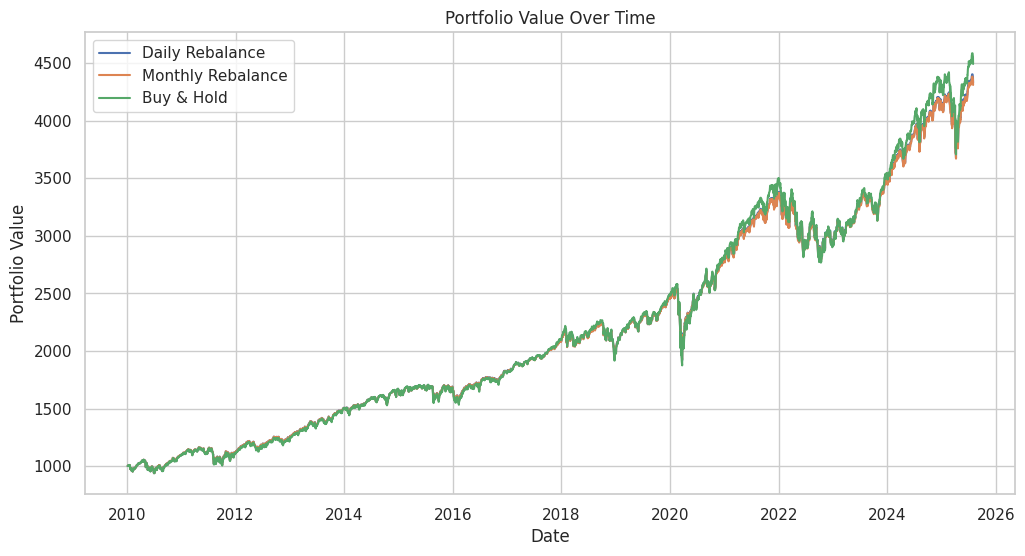

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily, label='Daily Rebalance')
plt.plot(monthly, label='Monthly Rebalance')
plt.plot(buy_hold, label='Buy & Hold')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import numpy as np

def compute_performance_metrics(portfolio_series, risk_free_rate=0.05):
    returns = portfolio_series.pct_change().dropna()
    total_days = (portfolio_series.index[-1] - portfolio_series.index[0]).days
    years = total_days / 365.25

    # CAGR
    final_value = portfolio_series.iloc[-1]
    initial_value = portfolio_series.iloc[0]
    cagr = (final_value / initial_value) ** (1 / years) - 1

    # Volatility
    vol = returns.std() * np.sqrt(252)

    # Sharpe (risk-free assumed constant)
    excess_return = cagr - risk_free_rate
    sharpe = excess_return / vol if vol != 0 else np.nan

    # Max drawdown
    running_max = portfolio_series.cummax()
    drawdown = portfolio_series / running_max - 1
    max_drawdown = drawdown.min()

    return {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }

# Collect all strategies
results = {
    "Daily": compute_performance_metrics(daily),
    "Monthly": compute_performance_metrics(monthly),
    "Buy & Hold": compute_performance_metrics(buy_hold),
    #"Threshold (5%)": compute_performance_metrics(threshold1)
}

# Display as DataFrame
performance_df = pd.DataFrame(results).T

# Optional: format it nicely
performance_df = performance_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)

print(performance_df)

              CAGR Volatility Sharpe Ratio Max Drawdown
Daily        9.86%     12.23%       39.71%      -24.58%
Monthly      9.82%     12.08%       39.90%      -24.19%
Buy & Hold  10.11%     13.50%       37.88%      -27.37%


/tmp/ipython-input-2362384281.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  performance_df = performance_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)


In [ ]:
threshold_results = {
    "Threshold (3%)": compute_performance_metrics(threshold1),
    "Threshold (5%)": compute_performance_metrics(threshold2),
    "Threshold (10%)": compute_performance_metrics(threshold3)
}

threshold_df = pd.DataFrame(threshold_results).T
threshold_df = threshold_df.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x)

In [26]:
print(threshold_df)

                  CAGR Volatility Sharpe Ratio Max Drawdown
Threshold (3%)   9.89%     12.24%       39.91%      -24.57%
Threshold (5%)   9.89%     12.25%       39.89%      -24.56%
Threshold (10%)  9.86%     12.57%       38.65%      -24.04%


In [30]:
print("Threshold (3%) rebalances:", count_t1)
print("Threshold (5%) rebalances:", count_t2)
print("Threshold (10%) rebalances:", count_t3)

Threshold (3%) rebalances: 20
Threshold (5%) rebalances: 7
Threshold (10%) rebalances: 1


### Rebalancing Strategy Comparison: Threshold Sensitivity

We evaluated a 70/30 portfolio of S&P 500 and T-Bills using threshold-based rebalancing with different drift tolerances:

| Threshold       | Sharpe Ratio | Rebalances |
|-----------------|--------------|------------|
| **3%**          | **39.91%**   | 20         |
| **5%**          | 39.89%       | 7          |
| **10%**         | 38.65%       | 1          |

---

#### Conclusion

Threshold-based rebalancing with a **5% drift limit** offers an excellent balance between performance and transaction efficiency:

- Nearly **optimal Sharpe ratio**
- **~65% fewer trades** compared to the tighter 3% threshold
- Much better risk-adjusted return than the loose 10% threshold, which essentially became buy-and-hold

This suggests that **5% drift tolerance** is a practical sweet spot for low-maintenance, high-efficiency portfolio management.
